Instructions: click restart and run all above. Figures will show once the entire notebook has finished running. This may take a few minutes

In [1]:
import sys
sys.path.append('..')
import os
import shutil
import copy
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib notebook

# Performing parameter space analysis on PDE models

This notebook will demonstrate how we can perform custom 2D parameter space analysis for a PDE model using functions in this package

## ParamSpace2D

This package contains a versatile class that can be used for performing 2D parameter space analysis on any model.

```python
p = ParamSpace2D(func, p1_range, p2_range, resolution0, direc, resolution_step=2, n_iterations=1, explore_boundaries=True, parallel=False)
```

The class takes the following arguments:
- func: Function to evaluate. Must take two parameter values as inputs, and return a single number representing a measure of model behaviour. This can be a float, in the case of a quantitative measure (e.g. asymmetry index, aPAR domain size), or an integer in the case of a quantitative measure (e.g. 0/1 = polarised/not polarised).
- p1_range: (lower, upper) bounds for parameter 1 (first argument to func)
- p2_range: (lower, upper) bounds for parameter 2 (second argument to func)
- resolution0: parameter grid resolution for first iteration
- direc: directory to save results
- resolution_step: factor by which to increase grid resolution with each iteration
- n_iterations: number of iterations to perform
- explore_boundaries: if True, the function will focus the parameter search to boundary regions in paramter space (in the case where the function returns a qualitative feature). This allows smooth boundaries to be resolved, whilst limiting the number of function evaluations.
- parallel: if True, will perform computations in parallel using python multitasking package, using all available cores

Parameter sweeps can be run by calling the run function.

In [2]:
from parmodel import ParamSpace2D

## Qualitative parameter space analysis

I will demonstrate how this can be used by performing a pA/pP (dosage of aPAR/pPAR) parameter sweep on the Goehring 2011 model, testing for the ability of the system to maintain a polarised state.

To do this, we must first set up an appropriate function to input into the ParamSpace2D class. The function must take pA and pP as inputs, perform a simulation, and return an integer representing the final state of the model. The function below returns one of three integers:
- 0: Unpolarised, aPAR dominant
- 1: Polarised
- 2: Unpolarised, pPAR dominant

We will use a pre-build PDE model for this

In [3]:
from models.pde.Goehring2011 import Goehring2011 

def func(pA, pP):
    """
    Performs a simulation with specified pA and pP, and returns an integer 
    corresponding the the final state of the model:
    - 0: Unpolarised, aPAR dominant
    - 1: Polarised
    - 2: Unpolarised, pPAR dominant
    
    """
    
    # Set up the model
    m = Goehring2011(pA=pA, pP=pP, Tmax=1000)
    
    # Run the model
    m.initiate()
    m.run(kill_uni=True)
    
    # Calculate state
    if sum(m.A > m.P) == len(m.A):
        return 0
    elif sum(m.A > m.P) == 0:
        return 2
    else:
        return 1

#### Create folder for saving results

We must specify a folder to save the final result of the parameter sweep. The function will also use this folder to save individual simulation results and keep track of which simulations have been performed.

In [4]:
path = '_temp'
if os.path.exists(path):
    shutil.rmtree(path)
os.mkdir(path)

#### Set up class

Set up a ParamSpace2D class, taking the above function as an input. We must also specify bounds for each parameter over which to explore parameter space. Setting these parameters to zero can throw errors so we will use 0.01 as the minumum.

The algorithm can be specified by setting the resolutuon0, resolution_step, n_iterations and explore_boundaries arguments. With the parameters specified below, the function will perform an initial 10x10 grid search on the first iteration. This will be followed by a the second iteration, in which resolution will be increased to (resolution0 * resolution_step) - 1 (=19x19), and parameter regimes close to a boundary will be evaluated.

We must also specify a directory in which to save the results, and will set parallel to True to speed up computation.

In [5]:
pA_range = [0.01, 1.56]
pP_range = [0.01, 1]

p = ParamSpace2D(func=func, p1_range=pA_range, p2_range=pP_range, resolution0=5, resolution_step=2,
                 n_iterations=2, explore_boundaries=True, direc=path, parallel=True)

#### Run

Run by calling the run function of the class

In [6]:
p.run()

0
1


../parmodel/paramspace.py:262: RuntimeWarning: All-NaN slice encountered
  mx = np.nanmax(x, axis=2)
../parmodel/paramspace.py:263: RuntimeWarning: All-NaN slice encountered
  mn = np.nanmin(x, axis=2)


After analysis has finished (will take a few minutes), the results folder will contain a set of files contianing the results of the analysis:
- a set of csv files (one for each iteration), which contain the results of every simulation performed at that iteration
- a 2D array saved as a txt file (Res.txt) containing the final parameter space map

We can import this data and plot the results

In [7]:
res = np.loadtxt(path + '/Res.txt')

<IPython.core.display.Javascript object>


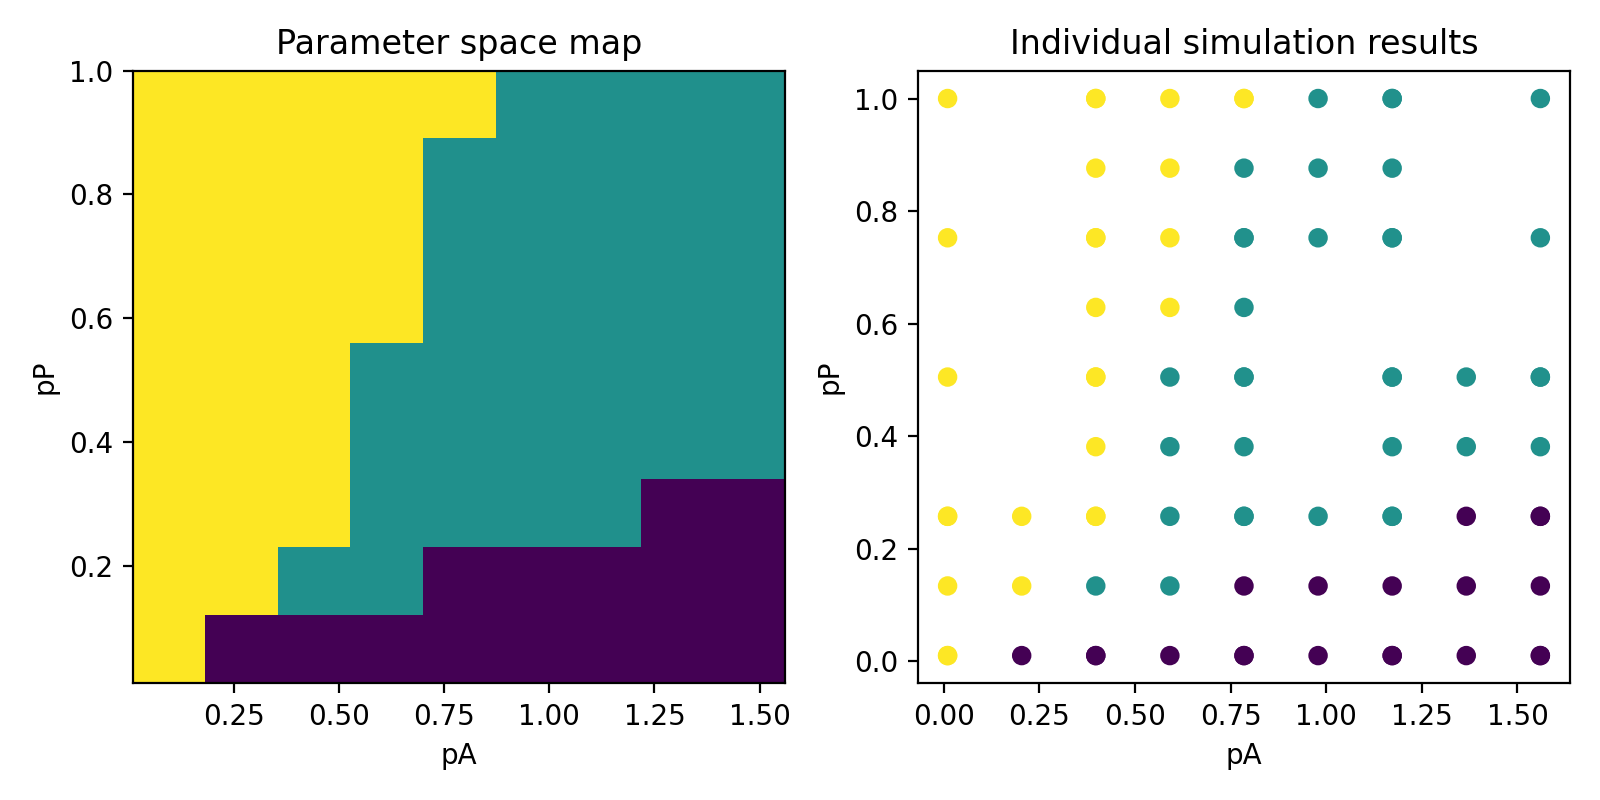

In [8]:
def paramspace_fig(res, iterations):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    
    ax1.imshow(res.T, origin='lower', extent=(pA_range[0], pA_range[1], pP_range[0], pP_range[1]), aspect='auto')
    ax1.set_xlabel('pA')
    ax1.set_ylabel('pP')
    ax1.set_title('Parameter space map')
    
    for i in range(iterations):
        df = pd.read_csv(path + '/%s.csv' % i, header=None)
        ax2.scatter(df[0], df[1], c=df[2]) 
    ax2.set_xlabel('pA')
    ax2.set_ylabel('pP')
    ax2.set_title('Individual simulation results')
        
    fig.set_size_inches(8, 4)
    fig.tight_layout()
    
paramspace_fig(res, iterations=2)

We can see three regions of parameter space, indicating a clear dependence of polarity on balanced protein amounts. However, the resolution of the parameter grid is low, and the boundaries between parameter domains are quite poorly defined. We can improve this by running analysis for a few more iterations.

#### Continuing analysis

We can increase resolution of the boundaries by performing another iteration of analysis. We can do this easily by calling the function again with exactly the same arguments, but setting n_iterations to a higher number. This will run the algorithm again from the begining, but will import the results from the first two iterations, rather than redoing these simulations.

We will run the analysis for two more iterations:

In [9]:
p = ParamSpace2D(func=func, p1_range=pA_range, p2_range=pP_range, resolution0=5, resolution_step=2,
                 n_iterations=4, direc=path, parallel=True)

In [10]:
p.run()

0
1
2
3


In [11]:
res2 = np.loadtxt(path + '/Res.txt')

<IPython.core.display.Javascript object>


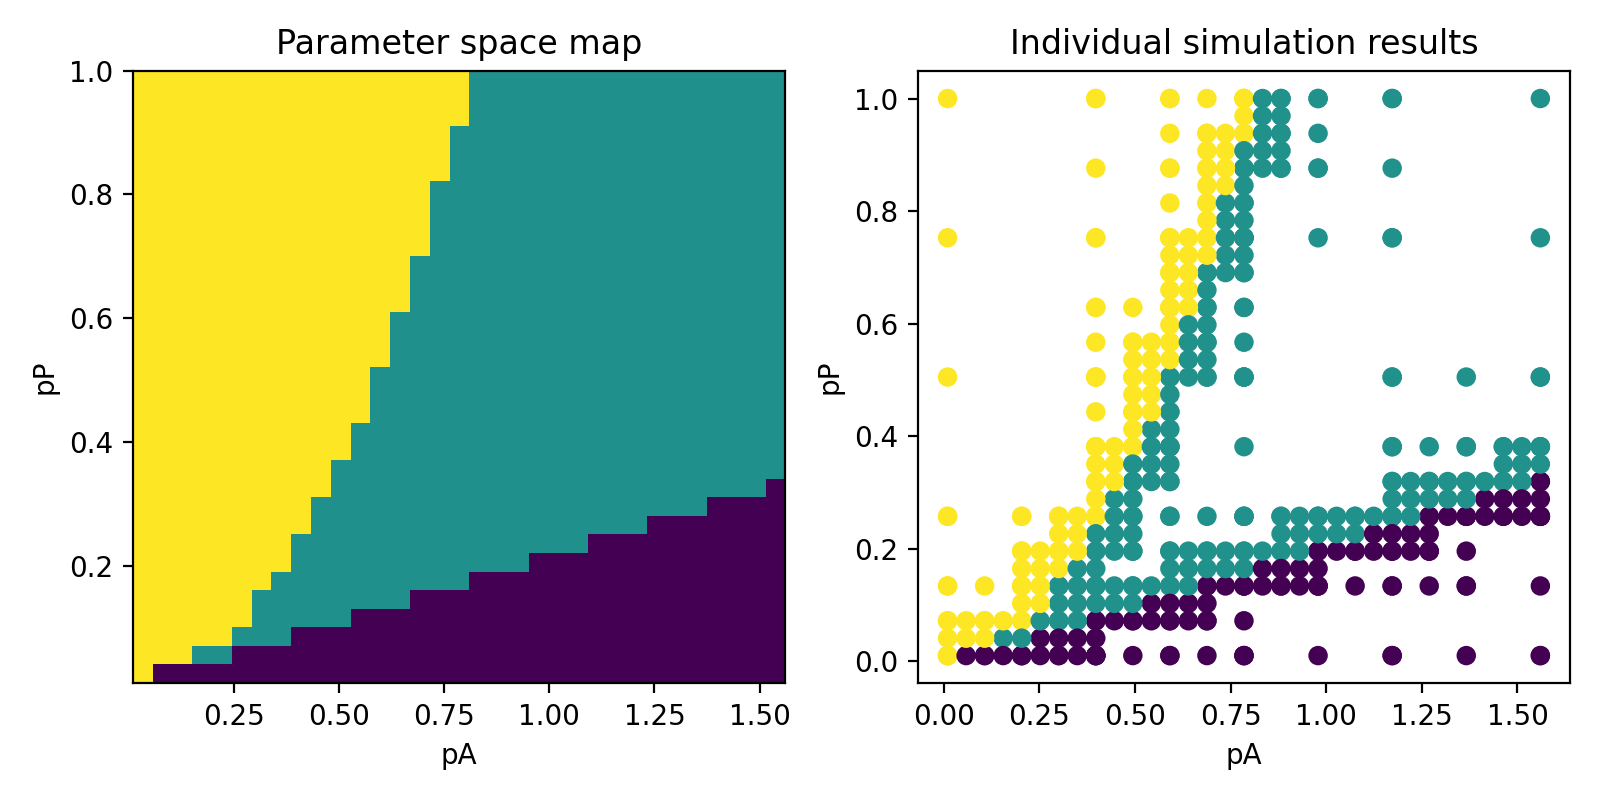

In [12]:
paramspace_fig(res2, iterations=4)

We now have a much cleaner parameter space map with sharper boundaries. This could be refined even further by running for more iterations, but we will not do this here

#### Viewing simulation results

It's helpful to view the final states of a few different models . The ParamSpace2D function will not save the full state of every model (only the output of func), but we can easily redo a few simulations and check the results. 

## Quantitative parameter space analysis

The same class can be used to perform a quantitative parameter space analysis, i.e. monitoring a quantitative model read-out, rather than a qualitative feature like above. This can take longer, as our search can no longer be refined to boundaries in the same way. I demonstrate this below, using aPAR ASI as a quantitative read-out of the model:

In [13]:
from models.pde.Goehring2011 import Goehring2011 

def func(pA, pP):
    """
    Performs a simulation with specified kAP and kPA, and returns a float representing ASI
    
    """
    
    # Set up the model
    m = Goehring2011(pA=pA, pP=pP, Tmax=1000)
    
    # Run the model
    m.initiate()
    m.run(kill_uni=True)
    
    # Calculate ASI of aPAR
    if sum(m.A > m.P) == len(m.A):
        return 0
    elif sum(m.A > m.P) == 0:
        return 0
    else: 
        ant = np.mean(m.A[:50])
        post = np.mean(m.A[50:])
        asi = abs((ant - post) / (2 * (ant + post)))
        return asi

#### Create results folder

In [14]:
path = '_temp2'
if os.path.exists(path):
    shutil.rmtree(path)
os.mkdir(path)

#### Run analysis

We will run for two iterations. This will not produce a clean parameter space map, and is just to demonstrate the idea. Running for more iterations would improve the map, but would take a long time so is best done on a machine with more cores.

In [15]:
pA_range = [0.01, 1.56]
pP_range = [0.01, 1]

p = ParamSpace2D(func=func, p1_range=pA_range, p2_range=pP_range, resolution0=5, resolution_step=2,
                 n_iterations=2, direc=path, parallel=False)

In [16]:
p.run()

0
1


#### Plot results

In [17]:
res3 = np.loadtxt(path + '/Res.txt')

<IPython.core.display.Javascript object>


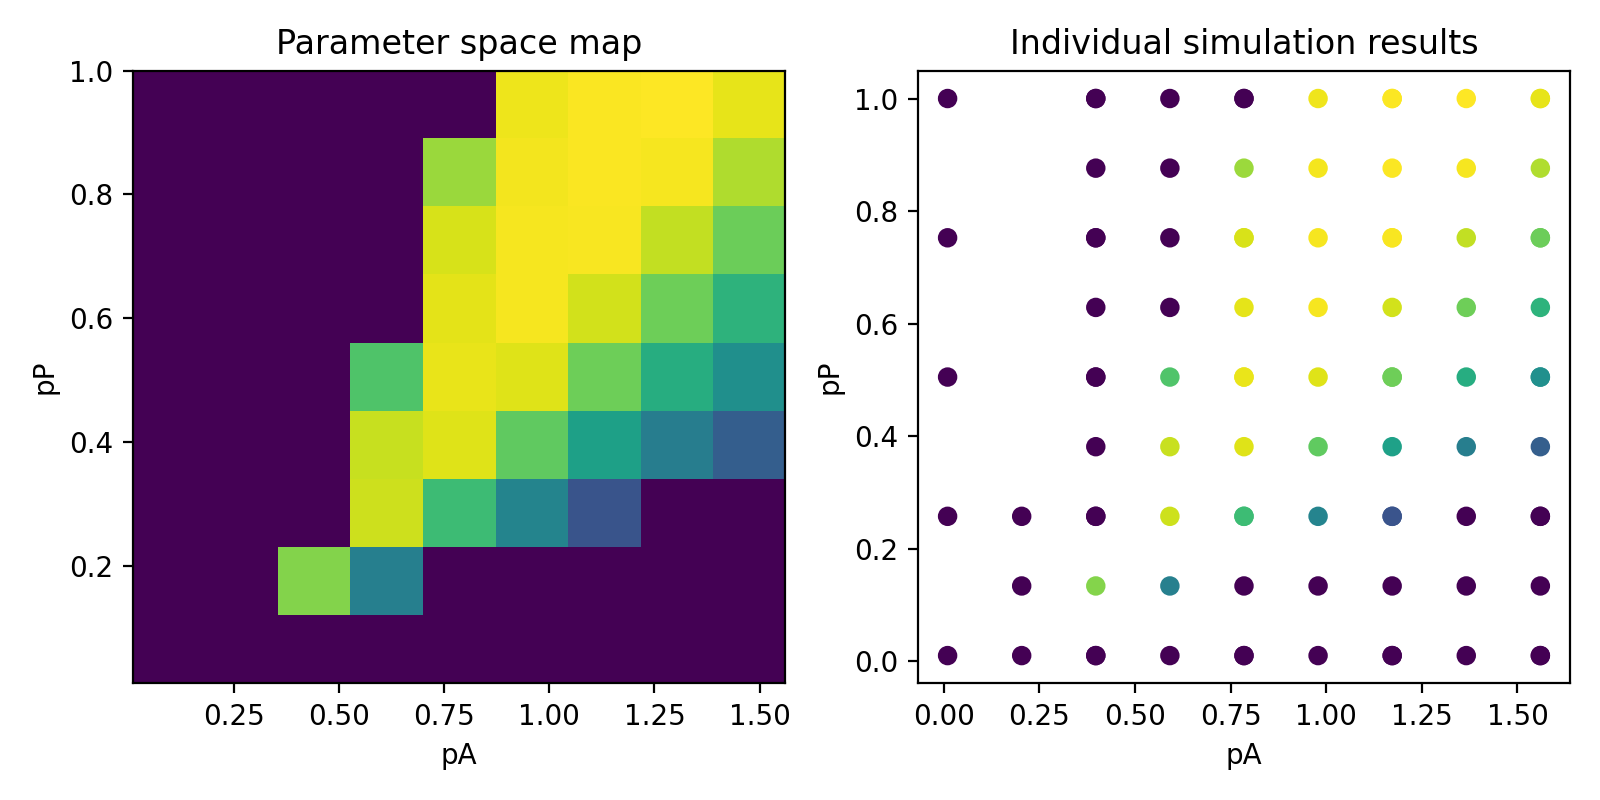

In [18]:
def paramspace_fig(res, iterations):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    
    ax1.imshow(res.T, origin='lower', extent=(pA_range[0], pA_range[1], pP_range[0], pP_range[1]), aspect='auto')
    ax1.set_xlabel('pA')
    ax1.set_ylabel('pP')
    ax1.set_title('Parameter space map')
    
    for i in range(iterations):
        df = pd.read_csv(path + '/%s.csv' % i, header=None)
        ax2.scatter(df[0], df[1], c=df[2]) 
    ax2.set_xlabel('pA')
    ax2.set_ylabel('pP')
    ax2.set_title('Individual simulation results')
        
    fig.set_size_inches(8, 4)
    fig.tight_layout()
    
paramspace_fig(res3, iterations=2)

We can see that ASI tends to be higher in the upper-right portion of parameter space, where dosages are high and balanced

## Summary

With the above analysis, I have demonstrated an easy method for performing 2D parameter space analysis, using the ParamSpace2D class. This class is highly versatile, can be used for any model, any combination of parameters, and any behaviour that can be summarised with a single number. By focusing simulations on the boundaries between regions in parameter space, we can quickly generate parameter space maps with sharp boundaries, minimising the number of simulations we have to perform. A few examples of possible scoring functions are shown below.

One cautionary note: This function can guarantee to fully explore any boundary that is captured in the first iteration. However, if a boundary is not found in the first iteration, then it may be missed altogether. Therefore, it is important that resolution0 is high enough. This will depend on the problem, and in most cases this doesn't need to be high (e.g. 5). If there is a small domain between two other domains then the algorithm will usually pick this up but could take a few iterations to get there.

#### Qualitative score for boundary position

This will give a score reflecting whether the polarity boundary is left or right of centre. The bounding line will indicate regions of parameter space where the domain boundary is perfectly centered.

In [ ]:
def par_state_bp(a, p):
    if sum(a > p) == len(a):
        # Unpolarised, A dominant
        return 0
    elif sum(a > p) == 0:
        # Unpolarised, P dominant
        return 0
    else:
        if sum(a > p) < len(a) // 2:
            # Polarised, boundary anterior of centre
            return 1
        elif sum(a > p) > len(a) // 2:
            # Polarised, boundary posterior of centre
            return 2
        elif abs(a[len(a) // 2] - p[len(a) // 2]) > abs(a[(len(a) // 2) - 1] - p[(len(a) // 2) - 1]):
            # Polarised, boundary just anterior of centre
            return 1
        else:
            # Polarised, boundary just posterior of centre
            return 2

#### Domain concentration

Will check whether the system is polarised, and return the pPAR domain concentration if so (defined loosely here as the concentration at hte extreme posterior)

In [ ]:
def par_state_dc(a, p):
    if sum(a > p) == len(a):
        # A dominant
        return 0
    elif sum(a > p) == 0:
        # P dominant
        return 0
    else:
        # Polarised
        return p[-1]

#### Qualitative ASI map

Will check whether the system is polarised, and return a qualitative score representing aPAR ASI. Useful for building a contour map for ASI

In [ ]:
def par_state_asi_a(a, p):
    if sum(a > p) == len(a):
        # A dominant
        return 0
    elif sum(a > p) == 0:
        # P dominant
        return 0
    else:
        # Polarised
        ant = np.mean(a[:50])
        post = np.mean(a[50:])
        asi = abs((ant - post) / (2 * (ant + post)))
        if asi < 0.2:
            return 1
        elif asi < 0.35:
            return 2
        elif asi < 0.45:
            return 3
        elif asi < 0.49:
            return 4
        else:
            return 5